# Inference Script

**Author:** Prisca Dotti

**Last modified:** 15.02.2024

Use this script to load a sample movie and run preprocessing suggested in "A New Approach to the Detection and Statistical Classification of Ca2+ Sparks", by Bányász et al.

Two ideas:
1. only apply filtering to movies + cell mask to annotations and train U-Net again
2. Apply whole algorithm to cell to detect sparks and then find a way to compare them automatically with our annotations & re-train U-Net


### Conclusions

After implementing and running the script, it appears that the script is not working as expected. The ground truth contains 69 true sparks, but the script is not able to detect all of them accurately.

Possible reasons for the discrepancy between the expected and actual results could be:

1. Noisy sample: preprocess and better denoise sample (but then again it is not fully automatic)
2. Find better thresholds
not be capturing all the relevant characteristics of sparks. Exploring alternative feature extraction techniques or incorporating additional features could potentially enhance the accuracy of spark detection.
3. Find better statistical tests

In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
# To import modules from parent directory in Jupyter Notebook
import sys

sys.path.append("..")

In [2]:
# Required imports
import os
import numpy as np
import imageio
import pandas as pd
import matplotlib.pyplot as plt
import napari

from scipy.ndimage import uniform_filter, convolve, median_filter, label, center_of_mass
from scipy.stats import t, wilcoxon

from config import TrainingConfig, config
from utils.training_inference_tools import get_final_preds
from utils.training_script_utils import init_model
import torch
import torch.nn as nn

### Function Definitions

In [3]:
def load_movie(movie_path):
    return np.asarray(imageio.volread(movie_path))

In [4]:
def normalize_movies(frames):
    # Assuming the first few frames can serve as a baseline for normalization
    normalizing_frame = np.median(frames[:10], axis=0)
    return frames / (normalizing_frame + 1e-6)  # Prevent division by zero

In [5]:
def apply_boxcar_filter(frames, filter_size=5):
    """
    Apply a 5x5 boxcar filter to each 2D frame in a 3D numpy array of frames.
    Attenuates objects having spatial size of <~1.um (5x pixel size of 0.2 um).

    Parameters:
    - frames: A 3D numpy array with shape (num_frames, height, width).
    - filter_size: Size of the boxcar filter, default is 5.

    Returns:
    - A 3D numpy array with the filtered frames.
    """
    # Apply the boxcar filter to each frame
    filtered_frames = np.array(
        [uniform_filter(frame, size=filter_size) for frame in frames]
    )
    return filtered_frames

In [6]:
def difference_and_threshold(frames, threshold=0.1):
    # Remark: Custom threshold based on expected Ca²⁺ event intensities
    diff_frames = np.diff(frames, axis=0)

    # flattened_data = diff_frames.flatten()
    # median_intensity = np.median(flattened_data)
    # std_intensity = np.std(flattened_data)

    # dynamic_threshold = median_intensity + (2 * std_intensity)
    # print("Dynamic threshold: ", dynamic_threshold)

    thresholded_frames = np.append(
        (diff_frames > threshold).astype(np.uint8),
        # (diff_frames > dynamic_threshold).astype(np.uint8),
        np.zeros_like(frames[:1]),  # Add missing frame at the end
        axis=0,
    ).astype(np.uint8)

    # Repeat the last frame to match the number of frames
    diff_frames = np.concatenate([diff_frames, diff_frames[-1:]], axis=0)

    return diff_frames, thresholded_frames

In [7]:
def live_or_die_filter_frame(binary_image, n_size=7, n_live=12, n_generation=3):
    """
    Applies the "live-or-die" algorithm to a binary image.

    From: "Theoretical analysis of the Ca2+ spark amplitude distribution" by
    Izu, L.T., et al. (1998)

    Parameters:
    - binary_image: A 2D numpy array where potential spark pixels are marked as
                    1 and all others as 0.
    - n_size: Size of the square neighborhood.
    - n_live: Minimum number of live neighbors required for a pixel to survive.
    - n_generation: Number of iterations the algorithm runs for.

    Returns:
    - A 2D numpy array after applying the "live-or-die" filtering.
    """
    # Create a square kernel of size Nsize x n_size for boxcar averaging
    kernel = np.ones((n_size, n_size), dtype=np.float32)
    for _ in range(n_generation):
        # Perform boxcar averaging
        neighbor_count = convolve(
            binary_image.astype(np.float32), kernel, mode="constant", cval=0
        )
        # Apply thresholding based on n_live
        binary_image = neighbor_count >= n_live
    return binary_image


def live_or_die_filter(binary_movie, n_size=4, n_live=7, n_generation=3):
    """
    Applies the "live-or-die" algorithm to a 3D binary movie.

    Parameters:
    - binary_movie: A 3D numpy array where potential spark pixels are marked as
                    1 and all others as 0.
    - n_size: Size of the square neighborhood.
    - n_live: Minimum number of live neighbors required for a pixel to survive.
    - n_generation: Number of iterations the algorithm runs for.

    Returns:
    - A 3D numpy array after applying the "live-or-die" filtering.
    """
    filtered_movie = np.zeros_like(binary_movie)

    for i, frame in enumerate(binary_movie):
        filtered_movie[i] = live_or_die_filter_frame(
            frame, n_size, n_live, n_generation
        )

    return filtered_movie

In [8]:
def detect_inside_cell(normalizing_frame, n_size=7, n_live=3, n_generation=1):
    """
    Detects the inside of the cell by creating a binary image based on the median
    threshold and refining it using the live-or-die algorithm.

    Parameters:
    - normalizing_frame: A 2D numpy array representing the normalizing frame.
    - Nsize: Size of the neighborhood for the live-or-die algorithm.
    - Nlive: Minimum number of "live" neighbors for a pixel to be considered inside the cell.
    - Ngeneration: Number of iterations for the live-or-die algorithm.

    Returns:
    - A binary 2D numpy array representing the inside of the cell.
    """
    # Step 1: Create a binary image based on the median value
    median_value = np.median(normalizing_frame)
    binary_image = normalizing_frame >= median_value
    # Apply median filter to smooth the binary image before live-or-die to reduce noise
    binary_image_smoothed = median_filter(binary_image, size=3)
    # Step 2: Refine the binary image using the live-or-die filter
    return live_or_die_filter_frame(
        binary_image_smoothed, n_size=n_size, n_live=n_live, n_generation=n_generation
    )

In [9]:
def find_sparks(movie, threshold_movie, inside_cell):
    """
    Finds the coordinates of sparks within the cell interior for a sequence of images.

    Parameters:
    - movie: A 3D numpy array representing the sequence of images.
    - threshold_movie: A binary 3D numpy array where potential sparks are marked.
    - inside_cell: A binary 2D numpy array representing the cell interior.

    Returns:
    - spark_info: A list of dictionaries, each containing the center of mass coordinates,
      spark area, and blob number for each identified spark within the cell.
    """
    spark_info = []
    for i, (frame, threshold_frame) in enumerate(zip(movie, threshold_movie)):
        # Multiply the binary images to isolate sparks within the cell interior
        binary_spark_image = np.logical_and(inside_cell, threshold_frame)

        # Label and identify each isolated spark
        labeled_image, num_features = label(binary_spark_image)

        for blob_number in range(1, num_features + 1):
            # Isolate each spark based on its label
            blob_mask = labeled_image == blob_number
            isolated_spark = frame * blob_mask

            # Calculate the center of mass for the isolated spark
            center = center_of_mass(isolated_spark, labels=blob_mask)  # y, x

            # Record spark information
            spark_area = np.sum(blob_mask)
            spark_info.append(
                {
                    "center_of_mass": center,
                    "spark_area": spark_area,
                    "blob_number": blob_number,
                    "frame_number": i,
                }
            )
    return spark_info

In [10]:
def classify_sparks(
    candidate_sparks,
    fluorescence_frames,
    threshold_a=0.01,
    threshold_b=0.025,
    n_size=3,
    pre_frames=6,
):
    """
    Classifies candidate sparks based on statistical tests.

    Parameters:
    - candidate_sparks: List of dictionaries containing spark information including 'center_of_mass' and 'frame_index'.
    - fluorescence_frames: 3D numpy array of fluorescence values with shape (num_frames, height, width).
    - threshold_a: Threshold for the probability that the fluorescence increase is due to chance (for frame k).
    - threshold_b: Threshold for the subsequent frame (k + 1).
    - n_size: Size of the neighborhood for calculating local fluorescence statistics.
    - pre_frames: Number of frames before the spark to use for calculating local fluorescence statistics.

    Returns:
    - A list of classified sparks (only those considered true sparks).
    """
    true_sparks = []
    half_n_size = n_size // 2

    for spark in candidate_sparks:
        y, x = spark["center_of_mass"]
        frame_number = spark["frame_number"]

        # Cast to int to avoid numpy indexing errors
        x, y = int(x), int(y)

        # Ensure coordinates and frame index are within bounds
        if not (
            half_n_size <= x < fluorescence_frames.shape[2] - half_n_size
            and half_n_size <= y < fluorescence_frames.shape[1] - half_n_size
        ):
            continue  # Coordinates out of bounds
        if not (pre_frames <= frame_number < fluorescence_frames.shape[0] - 1):
            continue  # Not enough frames for analysis

        # Calculate local fluorescence statistics in the neighborhood around the spark
        local_frames = fluorescence_frames[
            frame_number - pre_frames : frame_number - 1,
            y - half_n_size : y + half_n_size + 1,
            x - half_n_size : x + half_n_size + 1,
        ]
        m = np.mean(local_frames)
        s = np.std(local_frames)

        f_k = np.mean(
            fluorescence_frames[
                frame_number,
                y - half_n_size : y + half_n_size + 1,
                x - half_n_size : x + half_n_size + 1,
            ]
        )
        f_k_plus_1 = np.mean(
            fluorescence_frames[
                frame_number + 1,
                y - half_n_size : y + half_n_size + 1,
                x - half_n_size : x + half_n_size + 1,
            ]
        )

        # Calculate t-scores and p-values for frames k and k+1
        t_score_k = (f_k - m) / s if s > 0 else np.inf
        p_value_k = t.sf(
            np.abs(t_score_k), df=pre_frames - 2
        )  # df=4 because sample size is 5 (k-6 to k-2)

        t_score_k_plus_1 = (f_k_plus_1 - m) / s if s > 0 else np.inf
        p_value_k_plus_1 = t.sf(np.abs(t_score_k_plus_1), df=pre_frames - 2)

        # Apply thresholds to classify the spark
        if p_value_k < threshold_a and p_value_k_plus_1 < threshold_b:
            true_sparks.append(spark)

    return true_sparks

In [11]:
def classify_sparks_wilcoxon(
    candidate_sparks,
    fluorescence_frames,
    significance_level=0.05,
    n_size=3,
    pre_frames=6,
):
    true_sparks = []
    for spark in candidate_sparks:
        y, x = spark["center_of_mass"]
        frame_number = spark["frame_number"]
        x, y = int(x), int(y)

        # Ensure frame index is within bounds
        if not pre_frames <= frame_number:
            continue

        # Collect pre-spark and during-spark fluorescence intensities
        pre_spark_intensities = fluorescence_frames[
            frame_number - pre_frames : frame_number - 1,
            y - n_size : y + n_size + 1,
            x - n_size : x + n_size + 1,
        ]
        pre_spark_intensities = np.mean(pre_spark_intensities, axis=0)

        during_spark_intensities = fluorescence_frames[
            frame_number : frame_number + 2,
            y - n_size : y + n_size + 1,
            x - n_size : x + n_size + 1,
        ]
        during_spark_intensities = np.mean(during_spark_intensities, axis=0)

        # Perform the Wilcoxon signed-rank test
        d = pre_spark_intensities.flatten() - during_spark_intensities.flatten()
        d = d[np.nonzero(d)]
        _, p_value = wilcoxon(
            d,
            alternative="greater",
        )

        # Check if the p-value is less than the significance level
        if p_value < significance_level:
            true_sparks.append(spark)

    return true_sparks

In [12]:
def analyze_movie(movie_data):
    """
    Analyzes the distribution of fluorescence intensity in the movie data.

    Parameters:
    - movie_data: A 3D numpy array with shape (num_frames, height, width), representing the fluorescence movie.

    Outputs:
    - Histograms of fluorescence intensity
    - Statistical summary (mean, median, standard deviation, min, and max values)
    """
    # Flatten the movie data to analyze the distribution of all pixels across all frames
    flattened_data = movie_data.flatten()

    # Calculate basic statistics
    shape = movie_data.shape
    mean_intensity = np.mean(flattened_data)
    median_intensity = np.median(flattened_data)
    std_intensity = np.std(flattened_data)
    min_intensity = np.min(flattened_data)
    max_intensity = np.max(flattened_data)

    return (
        shape,
        mean_intensity,
        median_intensity,
        std_intensity,
        min_intensity,
        max_intensity,
    )

In [13]:
def get_number_of_labeled_sparks(class_mask, event_mask):
    """
    Get the number of labeled sparks.

    Parameters:
    - class_mask: A 3D numpy array representing the classes of the events.
    - event_mask: A 3D numpy array representing the IDs of the events.

    Returns:
    - The number of labeled sparks.
    """

    # Get sparks mask
    sparks_mask = class_mask == 1
    # Get spark events mask
    spark_events_mask = event_mask * sparks_mask
    # Get the number of labeled sparks
    return len(np.unique(spark_events_mask)) - 1

### Script Execution Flow

In [20]:
movie_ids = ["05", "10", "15", "20", "25", "32", "34", "40", "45"]

# movie_ids = [
#     "01",
#     "02",
#     "03",
#     "04",
#     "05",
#     "06",
#     "07",
#     "08",
#     "09",
#     "10",
#     "11",
#     "12",
#     "13",
#     "14",
#     "15",
#     "16",
#     "17",
#     "18",
#     "19",
#     "20",
#     "21",
#     "22",
#     "23",
#     "24",
#     "25",
#     "27",
#     "28",
#     "29",
#     "30",
#     "32",
#     "33",
#     "34",
#     "35",
#     "36",
# ]


dataset_path = os.path.join("..", "data", "sparks_dataset")

In [21]:
# Load movies
movie_paths = [
    os.path.join(dataset_path, f"{movie_id}_video.tif") for movie_id in movie_ids
]
movies_data = {
    movie_id: load_movie(movie_path)
    for movie_id, movie_path in zip(movie_ids, movie_paths)
}

# Filter the movie
normalized_movies = {
    movie_id: normalize_movies(movie_data)
    for movie_id, movie_data in movies_data.items()
}
filtered_movies = {
    movie_id: apply_boxcar_filter(normalized_movie)
    for movie_id, normalized_movie in normalized_movies.items()
}

# Get the difference and thresholded movies
threshold = 0.25
diff_movies = {
    movie_id: difference_and_threshold(filtered_movie, threshold=threshold)[0]
    for movie_id, filtered_movie in filtered_movies.items()
}
threshold_movies = {
    movie_id: difference_and_threshold(filtered_movie, threshold=threshold)[1]
    for movie_id, filtered_movie in filtered_movies.items()
}

# Run the live-or-die filter on the thresholded movie
n_size = 4
n_live = 7
n_generation = 3

filtered_threshold_movies = {
    movie_id: live_or_die_filter(threshold_movie, n_size, n_live, n_generation).astype(
        np.uint8
    )
    for movie_id, threshold_movie in threshold_movies.items()
}

# Compute cell mask
n_size = 7
n_live = 3
n_generation = 1

normalizing_frames = {
    movie_id: np.median(filtered_movie[:10], axis=0)
    for movie_id, filtered_movie in movies_data.items()
}

inside_cell_masks = {
    movie_id: detect_inside_cell(normalizing_frame, n_size, n_live, n_generation)
    for movie_id, normalizing_frame in normalizing_frames.items()
}

In [22]:
# Load annotations
class_labels_paths = [
    os.path.join(dataset_path, f"{movie_id}_class_label.tif") for movie_id in movie_ids
]
class_labels = {
    movie_id: load_movie(class_labels_path)
    for movie_id, class_labels_path in zip(movie_ids, class_labels_paths)
}

event_labels_paths = [
    os.path.join(dataset_path, f"{movie_id}_event_label.tif") for movie_id in movie_ids
]
event_labels = {
    movie_id: load_movie(event_labels_path)
    for movie_id, event_labels_path in zip(movie_ids, event_labels_paths)
}

# Get the number of labeled sparks
n_labeled_sparks = {
    movie_id: get_number_of_labeled_sparks(
        class_labels[movie_id], event_labels[movie_id]
    )
    for movie_id in movie_ids
}

In [23]:
# Get U-Net predictions
config_path = os.path.join("config_files", "config_final_model.ini")
params = TrainingConfig(training_config_file=config_path)
params.run_name = "final_model"
model_filename = f"network_100000.pth"

### Configure UNet ###
params.set_device(device="auto")
# params.set_device(device="cpu")  # temporary

network = init_model(params=params)

# Move the model to the GPU if available
if params.device.type != "cpu":
    network = nn.DataParallel(network).to(params.device, non_blocking=True)
    # cudnn.benchmark = True

# Path to the saved model checkpoint
models_relative_path = os.path.join(
    "models", "saved_models", params.run_name, model_filename
)
model_dir = os.path.realpath(os.path.join(config.basedir, models_relative_path))

# Load the model state dictionary
try:
    network.load_state_dict(torch.load(model_dir, map_location=params.device))
except RuntimeError as e:
    if "module" in str(e):
        # The error message contains "module," so handle the DataParallel loading
        print(
            "Failed to load the model, as it was trained with DataParallel. Wrapping it in DataParallel and retrying..."
        )
        # Get current device of the object (model)
        temp_device = next(iter(network.parameters())).device

        network = nn.DataParallel(network)
        network.load_state_dict(torch.load(model_dir, map_location=params.device))

        print("Network should be on CPU, removing DataParallel wrapper...")
        network = network.module.to(temp_device)
    else:
        # Handle other exceptions or re-raise the exception if it's unrelated
        raise

[16:54:42] [  INFO  ] [   config   ] <310 > -- Loading C:\Users\dotti\Code\sparks_project\config_files\config_final_model.ini


In [24]:
n_predicted_sparks = {}
for movie_id in movie_ids:
    segmentation, instances = get_final_preds(
        model=network,
        params=params,
        movie=movies_data[movie_id],
    )

    # Get the number of predicted sparks
    sparks_mask = segmentation == 1
    spark_events_mask = instances * sparks_mask
    n_predicted_sparks[movie_id] = len(np.unique(spark_events_mask)) - 1

In [19]:
# Create empty list to store the dataframe
df_list = []

# Analyze the distribution of fluorescence intensity
for movie_id, movie_data in filtered_movies.items():
    analyzed_data = analyze_movie(movie_data)

    # Append the analyzed data to the dataframe
    df_list.append(
        {
            "Movie ID": movie_id,
            "Shape": analyzed_data[0],
            "Inside Cell Mask Shape": inside_cell_masks[movie_id].shape,
            "Mean Intensity": analyzed_data[1],
            "Median Intensity": analyzed_data[2],
            "Std Intensity": analyzed_data[3],
            "Min Intensity": analyzed_data[4],
            "Max Intensity": analyzed_data[5],
            "Number of Nonzero Values": np.count_nonzero(threshold_movies[movie_id]),
            "Number of Nonzero Values (Filtered)": np.count_nonzero(
                filtered_threshold_movies[movie_id]
            ),
            "Difference Movie Max": diff_movies[movie_id].max(),
            "Difference Movie Min": diff_movies[movie_id].min(),
        }
    )

    assert movie_data.shape == threshold_movies[movie_id].shape

# Create dataframe
df = pd.DataFrame(df_list)


# Print the dataframe
display(df)

,Movie ID,Shape,Inside Cell Mask Shape,Mean Intensity,Median Intensity,Std Intensity,Min Intensity,Max Intensity,Number of Nonzero Values,Number of Nonzero Values (Filtered),Difference Movie Max,Difference Movie Min
0,05,"(500, 64, 512)","(64, 512)",1.023611,1.013388,0.101967,0.522132,3.106897,4357,3779,1.220687,-0.937828
1,10,"(500, 64, 512)","(64, 512)",1.056690,1.038106,0.109665,0.771606,3.137698,493,263,0.484921,-0.386532
2,15,"(500, 64, 512)","(64, 512)",1.038120,1.028058,0.058140,0.783364,1.743210,6892,1409,0.424964,-0.396877
3,20,"(500, 64, 512)","(64, 512)",1.062591,1.042640,0.096800,0.706658,3.067690,28151,14543,0.864964,-0.518058
4,25,"(1000, 64, 512)","(64, 512)",0.961049,0.967547,0.058231,0.668508,1.539525,2263,254,0.575780,-0.405064
5,32,"(1000, 64, 512)","(64, 512)",1.043232,1.039596,0.051003,0.730432,1.856181,19897,1818,0.494173,-0.517914
6,34,"(904, 64, 512)","(64, 512)",1.071472,1.028980,0.195023,0.384812,4.735110,29343,22805,0.773269,-0.813859
7,40,"(1000, 64, 512)","(64, 512)",0.969532,1.008839,0.134795,0.471642,2.215622,1497,250,0.446675,-0.432388
8,45,"(1000, 64, 512)","(64, 512)",0.961719,0.973392,0.113818,0.618297,1.921984,2053,110,0.438434,-0.431311


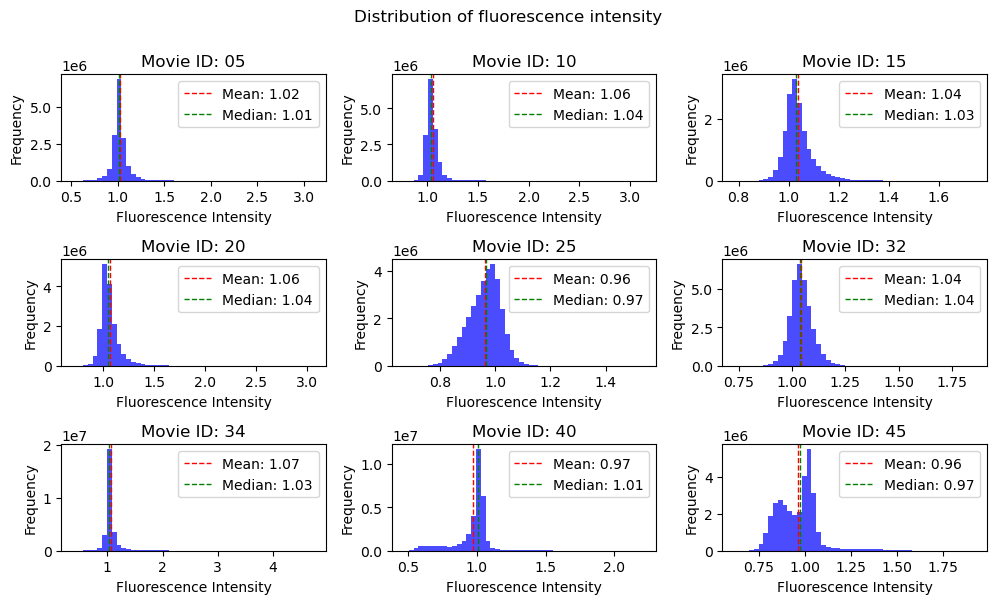

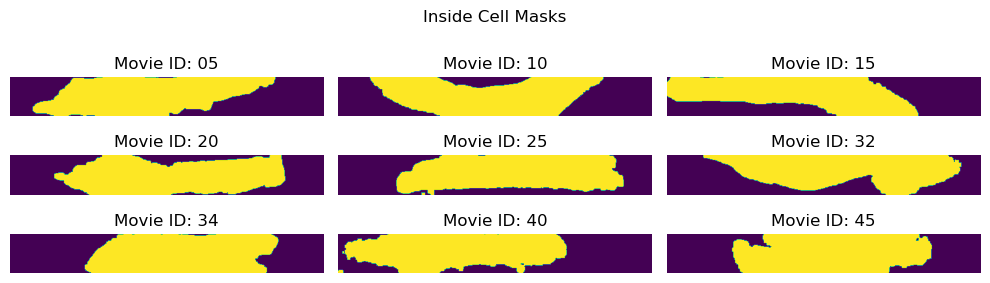

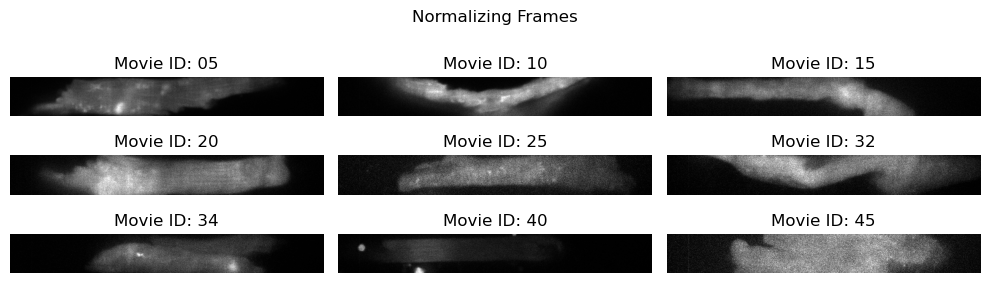

In [20]:
plt.figure(figsize=(10, 6))
# plt.rcParams.update({"font.size": 8})

n_cols = 3
n_rows = (
    len(movies_data) // n_cols
    if len(movies_data) % n_cols == 0
    else (len(movies_data) // n_cols) + 1
)

# Analyze the distribution of fluorescence intensity and plot histograms
for i, (movie_id, movie_data) in enumerate(filtered_movies.items()):
    ax = plt.subplot(n_rows, n_cols, i + 1)

    row = i // n_cols
    col = i % n_cols

    ax.hist(movie_data.flatten(), bins=50, color="blue", alpha=0.7)
    ax.set_title(f"Movie ID: {movie_id}")
    ax.set_xlabel("Fluorescence Intensity")
    ax.set_ylabel("Frequency")
    ax.axvline(
        np.mean(movie_data),
        color="r",
        linestyle="dashed",
        linewidth=1,
        label=f"Mean: {np.mean(movie_data):.2f}",
    )
    ax.axvline(
        np.median(movie_data),
        color="g",
        linestyle="dashed",
        linewidth=1,
        label=f"Median: {np.median(movie_data):.2f}",
    )
    ax.legend()

plt.suptitle("Distribution of fluorescence intensity", y=1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))

# Plot inside cell masks
n_cols = 3
for i, (movie_id, inside_cell) in enumerate(inside_cell_masks.items()):
    ax = plt.subplot(n_rows, n_cols, i + 1)

    row = i // n_cols
    col = i % n_cols

    ax.imshow(inside_cell)
    ax.set_title(f"Movie ID: {movie_id}")
    ax.axis("off")

plt.suptitle("Inside Cell Masks", y=1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))

# Plot normalizing frames
for i, (movie_id, normalizing_frame) in enumerate(normalizing_frames.items()):
    ax = plt.subplot(n_rows, n_cols, i + 1)

    row = i // n_cols
    col = i % n_cols

    ax.imshow(normalizing_frame, cmap="gray")
    ax.set_title(f"Movie ID: {movie_id}")
    ax.axis("off")

plt.suptitle("Normalizing Frames", y=1)
plt.tight_layout()
plt.show()

#### Find Sparks

In [25]:
# Get sparks candidates
spark_df_list = []

# Filter sparks according to statistical tests
# pre_frames = 19  # adapted to our dataset
pre_frames = 6  # original value
threshold_a = 0.05
threshold_b = 0.1

# Filter sparks according to the Wilcoxon signed-rank test
pre_frames = 10
significance_level = 0.15
n_size = 3

spark_coordinates_movies = {}
true_sparks_coordinates_movies = {}
true_sparks_wilcoxon_movies = {}

for movie_id in movie_ids:
    # Find sparks
    spark_coordinates = find_sparks(
        filtered_movies[movie_id],
        filtered_threshold_movies[movie_id],
        inside_cell_masks[movie_id],
    )

    # Classify sparks
    true_sparks_coordinates = classify_sparks(
        candidate_sparks=spark_coordinates,
        fluorescence_frames=normalized_movies[movie_id],
        pre_frames=pre_frames,
        threshold_a=threshold_a,
        threshold_b=threshold_b,
    )

    # Classify sparks using the Wilcoxon signed-rank test
    true_sparks_wilcoxon = classify_sparks_wilcoxon(
        candidate_sparks=spark_coordinates,
        fluorescence_frames=normalized_movies[movie_id],
        pre_frames=pre_frames,
        significance_level=significance_level,
        n_size=n_size,
    )

    spark_df_list.append(
        {
            "Movie ID": movie_id,
            "Number of Labeled Sparks": n_labeled_sparks[movie_id],
            "Number of Predicted Sparks": n_predicted_sparks[movie_id],
            "Number of Candidate Sparks": len(spark_coordinates),
            "Number of True Sparks (t-test)": len(true_sparks_coordinates),
            "Number of True Sparks (Wilcoxon)": len(true_sparks_wilcoxon),
        }
    )

    spark_coordinates_movies[movie_id] = spark_coordinates
    true_sparks_coordinates_movies[movie_id] = true_sparks_coordinates
    true_sparks_wilcoxon_movies[movie_id] = true_sparks_wilcoxon

spark_df = pd.DataFrame(spark_df_list)
display(spark_df)

,Movie ID,Number of Labeled Sparks,Number of Predicted Sparks,Number of Candidate Sparks,Number of True Sparks (t-test),Number of True Sparks (Wilcoxon)
0,05,71,117,125,31,2
1,10,22,33,11,0,0
2,15,42,25,94,0,2
3,20,70,81,472,12,41
4,25,31,63,24,0,4
5,32,7,6,148,0,7
6,34,16,57,534,99,108
7,40,6,8,14,0,3
8,45,0,14,9,0,1


In [19]:
spark_df.to_csv("banyasz_method_spark_summary.csv", index=False)

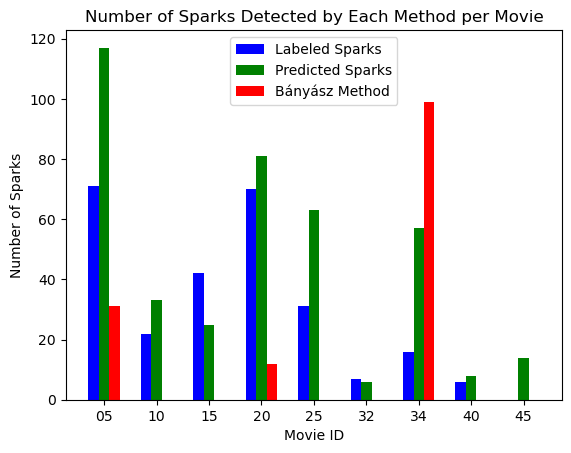

In [23]:
# Set the movie IDs as the x-axis labels
x_labels = spark_df["Movie ID"]

# Get the number of sparks detected by each method
labeled_sparks = spark_df["Number of Labeled Sparks"]
predicted_sparks = spark_df["Number of Predicted Sparks"]
ttest_sparks = spark_df["Number of True Sparks (t-test)"]
# wilcoxon_sparks = spark_df["Number of True Sparks (Wilcoxon)"]

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(x_labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
# r4 = [x + bar_width for x in r3]

# Create the bar plot
plt.bar(r1, labeled_sparks, color="b", width=bar_width, label="Labeled Sparks")
plt.bar(r2, predicted_sparks, color="g", width=bar_width, label="Predicted Sparks")
plt.bar(r3, ttest_sparks, color="r", width=bar_width, label="Bányász Method")
# plt.bar(r4, wilcoxon_sparks, color="y", width=bar_width, label="Wilcoxon Sparks")

# Add labels, title, and legend
plt.xlabel("Movie ID")
plt.ylabel("Number of Sparks")
plt.title("Number of Sparks Detected by Each Method per Movie")
plt.xticks([r + bar_width for r in range(len(x_labels))], x_labels)
plt.legend()

# Show the plot
plt.show()

### Optionally, visualize the process and results with Napari

In [27]:
idx = 0
movie_id = movie_ids[idx]
movie_data = movies_data[movie_id]
normalized_movie = normalized_movies[movie_id]
filtered_movie = filtered_movies[movie_id]
diff_movie = diff_movies[movie_id]
threshold_movie = threshold_movies[movie_id]
filtered_threshold_movie = filtered_threshold_movies[movie_id]

spark_coordinates = spark_coordinates_movies[movie_id]
true_sparks_coordinates = true_sparks_coordinates_movies[movie_id]
true_sparks_wilcoxon = true_sparks_wilcoxon_movies[movie_id]

In [28]:
viewer = napari.Viewer()
viewer.add_image(movie_data, name=f"input movie {movie_id}", visible=False)
viewer.add_image(normalized_movie, name="normalized movie")
viewer.add_image(filtered_movie, name="filtered movie")
viewer.add_image(diff_movie, name="diff movie")
viewer.add_labels(threshold_movie, name="thresholded movie", opacity=0.5, visible=False)
viewer.add_labels(
    filtered_threshold_movie, name="filtered thresholded movie", opacity=0.7
)
viewer.add_points(
    [
        (
            int(spark["frame_number"]),
            int(spark["center_of_mass"][0]),
            int(spark["center_of_mass"][1]),
        )
        for spark in spark_coordinates
    ],
    name="candidate sparks",
    face_color="white",
    size=5,
)
viewer.add_points(
    [
        (
            int(spark["frame_number"]),
            int(spark["center_of_mass"][0]),
            int(spark["center_of_mass"][1]),
        )
        for spark in true_sparks_coordinates
    ],
    name="true sparks",
    face_color="red",
    size=5,
    visible=False,
)

viewer.add_points(
    [
        (
            int(spark["frame_number"]),
            int(spark["center_of_mass"][0]),
            int(spark["center_of_mass"][1]),
        )
        for spark in true_sparks_wilcoxon
    ],
    name="true sparks wilcoxon",
    face_color="green",
    size=5,
)

[15:32:54] [WARNING ] [   vispy    ] <234 > -- DirectWrite: CreateFontFaceFromHDC() failed (Indicates an error in an input file such as a font file.) for QFontDef(Family="", pointsize=12, pixelsize=16, styleHint=5, weight=50, stretch=100, hintingPreference=0) LOGFONT("MS Sans Serif", lfWidth=0, lfHeight=-16) dpi=144


<Points layer 'true sparks wilcoxon' at 0x1ee9be8ea40>